In [1]:
suppressPackageStartupMessages({
    library(scater)
    library(scran)
    library(SingleCellExperiment)
    library(tidyverse)
    library(reticulate)
    library(batchelor)
    library(BiocParallel)
    library(logger)
    library(showtext)
    library(patchwork)
})
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 300)

In [2]:
log_info("Reading SCE object...")
sce_complete <- readRDS("../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered.rds")
log_info("SCE object done")

In [3]:
table(sce_complete$leiden_global_celltype)


                        B Cell            Blood CD16+ NK Cell 
                           657                            507 
               CD14+ Monocytes                      CD16- NK  
                           370                            309 
               CD16+ Monocytes           CD1c+ Dendritic Cell 
                           198                            318 
 CLEC9A+/LAMP3+ Dendritic Cell                    Endothelial 
                           118                           1189 
                   Hepatocytes                           ILCs 
                          1537                             37 
Liver bi-potent/Cholangiocytes                     Macrophage 
                           118                            579 
                     Mast Cell                     Mesenchyme 
                            58                            650 
                 Plasma B Cell             Proliferative T/NK 
                           270                        

In [4]:
sce <- sce_complete[, sce_complete$leiden_global_celltype == "Endothelial"]
sce <- logNormCounts(sce)

# Feature Selection

In [5]:
keep <- rowData(sce)$Biotype == "protein_coding"
dec <- modelGeneVar(sce, subset.row = keep, min.mean = 1, density.weights=TRUE)
hvgs <- getTopHVGs(dec, n = 3000)

# Clustering by scanpy

In [6]:
adata_sce <- zellkonverter::SCE2AnnData(sce, X_name = "logcounts")
sc <- import("scanpy")
adata_sce$var['highly_variable'] <- rownames(adata_sce$var) %in% hvgs
log_info("Run PCA")
sc$tl$pca(adata_sce, use_highly_variable=TRUE)

In [11]:
mt_pca <- adata_sce$obsm['X_pca']

In [12]:
mnn_out <- reducedMNN(mt_pca, batch = sce$donor, auto.merge = TRUE, k=10, BPPARAM = MulticoreParam(workers = 12))

Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped a

In [19]:
adata_sce$obsm$update(X_mnn = mnn_out$corrected)
sc$pp$neighbors(adata_sce, n_pcs = 50L, use_rep = "X_mnn" )
log_info("Run UMAP")
sc$tl$umap(adata_sce)
sc$tl$leiden(adata_sce, resolution = .8)
log_info("Convert back to sce")
sce <- zellkonverter::AnnData2SCE(adata_sce)

Note: Using stored X_name value 'logcounts'



In [20]:
reducedDim(sce, "PCA") <- reducedDim(sce, "X_pca")
reducedDim(sce, "UMAP") <- reducedDim(sce, "X_umap")


In [23]:
sce_old <- readRDS("../../../data/expression/sce/archive/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_stromal.rds")
ov_cells <- intersect(colnames(sce_old), colnames(sce))
colData(sce)[ov_cells, "old_anno"] <- as.character(colData(sce_old)[ov_cells, "leiden_sub_anno"])

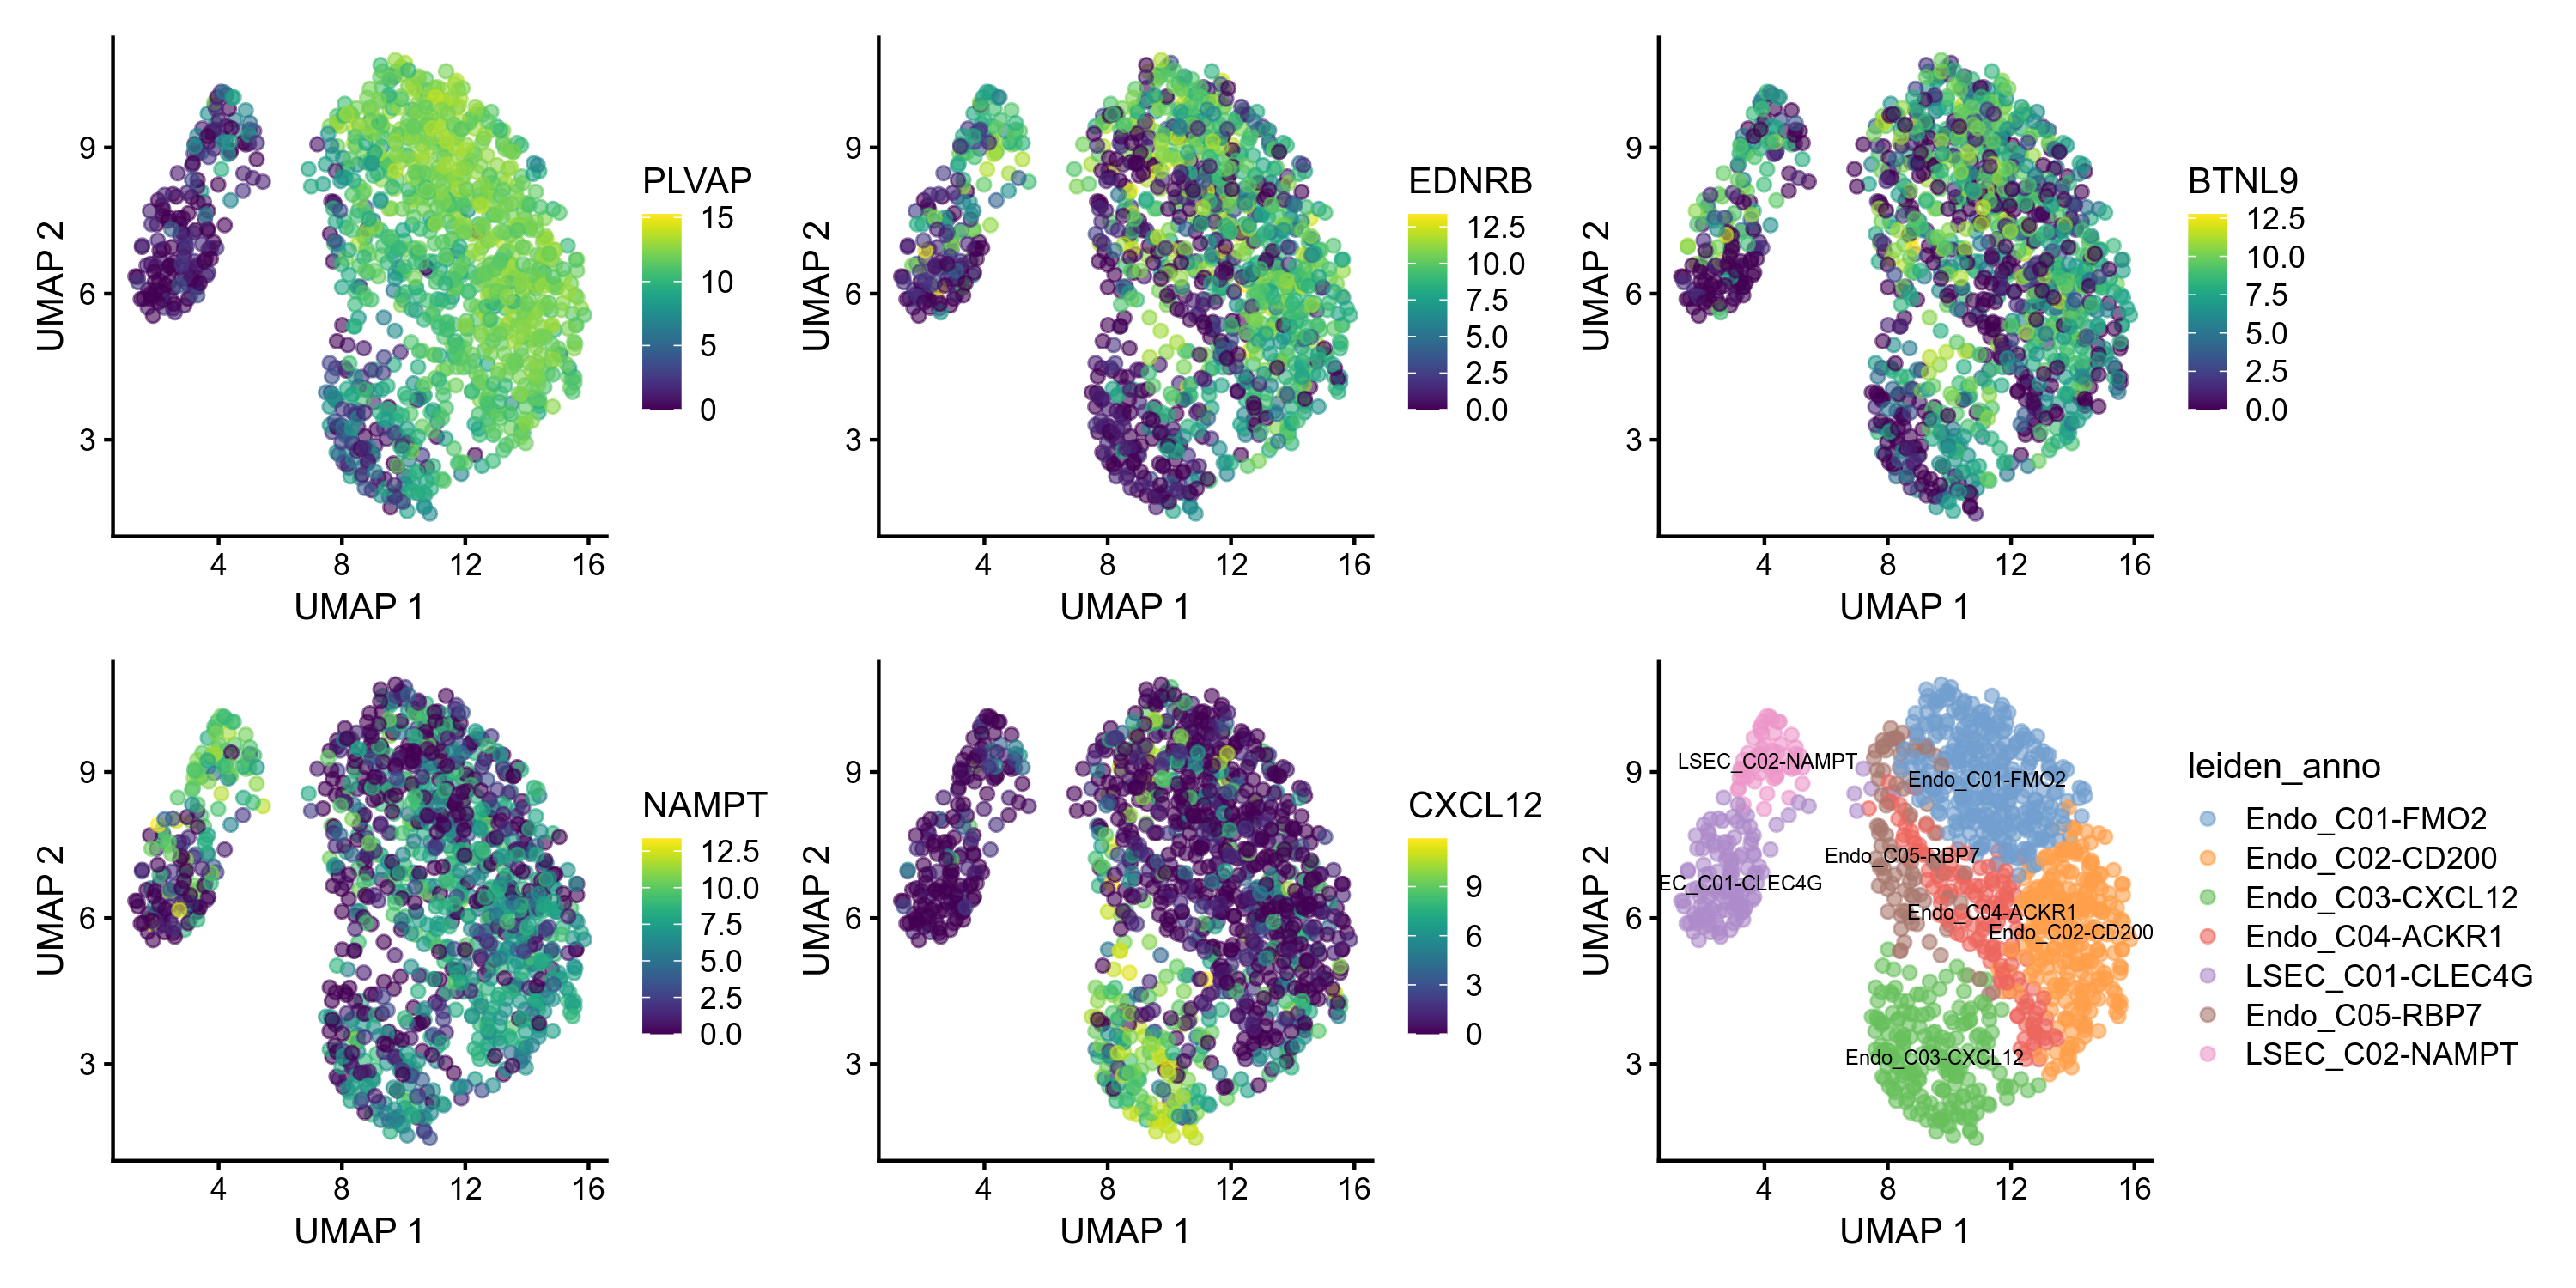

In [71]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)
p1 <- plotUMAP(sce, colour_by = 'PLVAP')
p2 <- plotUMAP(sce, colour_by = 'EDNRB')
p3 <- plotUMAP(sce, colour_by = 'BTNL9')
p4 <- plotUMAP(sce, colour_by = 'NAMPT')
p5 <- plotUMAP(sce, colour_by = 'CXCL12')
p6 <- plotUMAP(sce, colour_by = 'leiden_anno', text_by = 'leiden_anno', text_size = 2)


p1 + p2 + p3 + p4 + p5 + p6

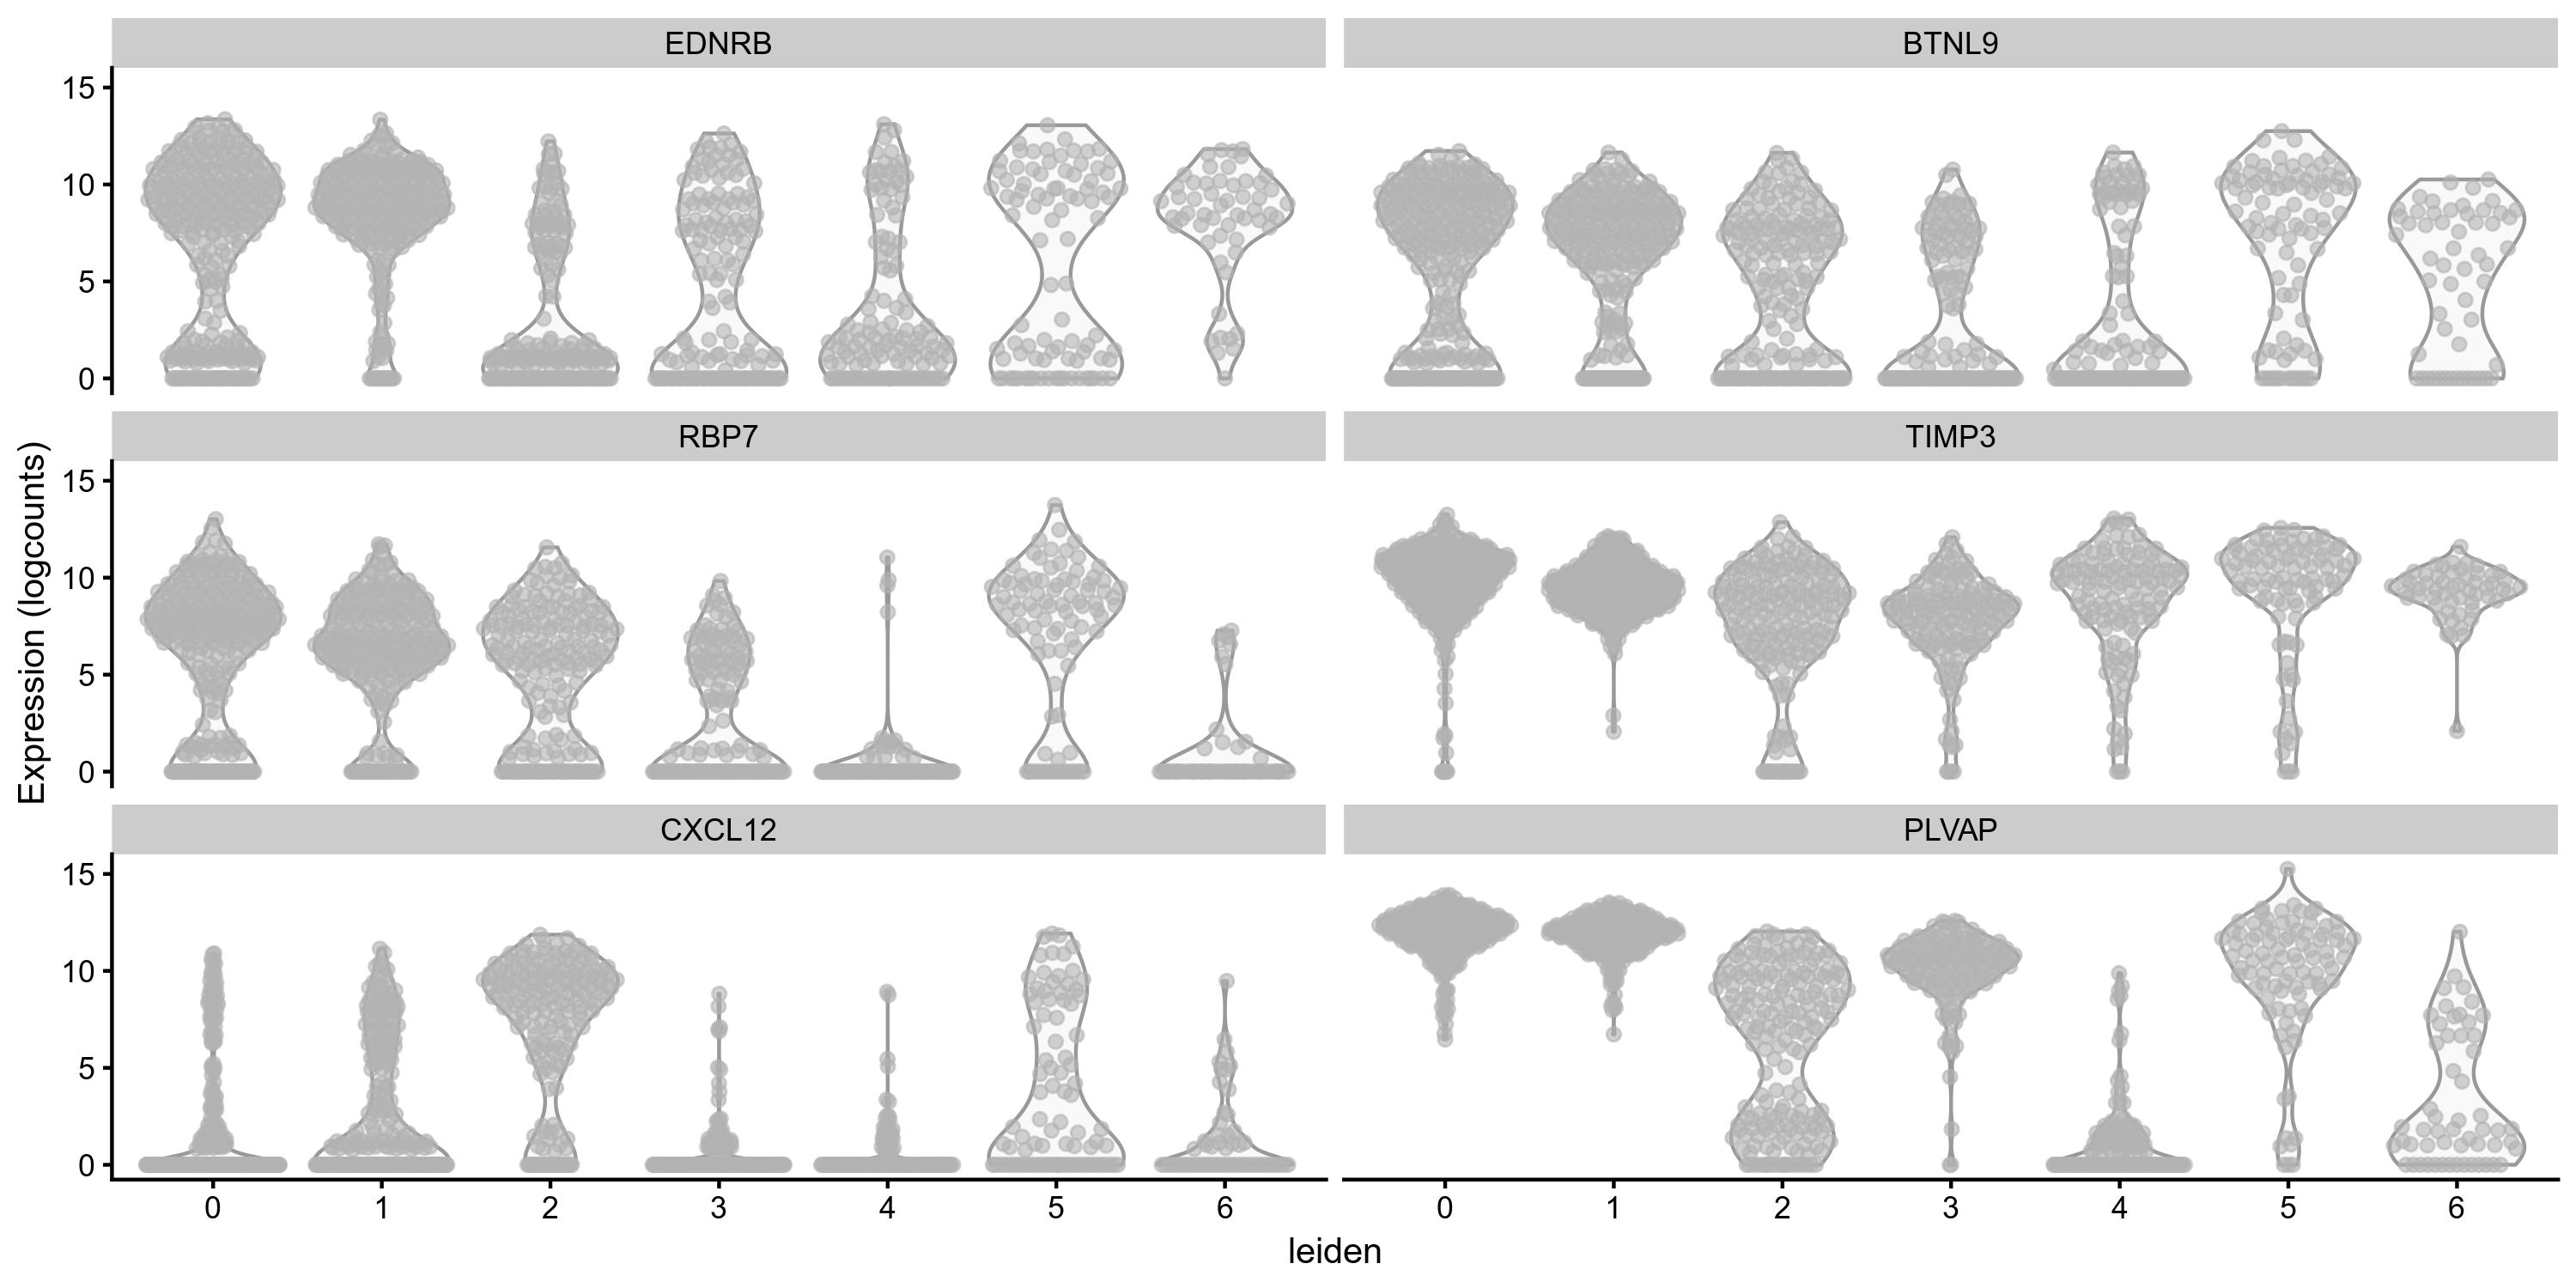

In [65]:
plotExpression(sce, x = "leiden", features = c("EDNRB", "BTNL9", "RBP7", "TIMP3", "CXCL12", "PLVAP"))

In [66]:
leiden2celltype <- c(
    '0' = 'Endo_C01-FMO2',
    '1' = 'Endo_C02-CD200',
    '2' = 'Endo_C03-CXCL12',
    '3' = 'Endo_C04-ACKR1',
    '4' = 'LSEC_C01-CLEC4G',
    '5' = 'Endo_C05-RBP7',
    '6' = 'LSEC_C02-NAMPT'
)
sce$leiden_anno <- plyr::mapvalues(x = sce$leiden, from = names(leiden2celltype), to = leiden2celltype)

In [69]:
keep <- rowData(sce)$Biotype == 'protein_coding'
markers <- findMarkers(sce, groups = sce$leiden_anno, lfc = 1, direction = 'up', subset.row = keep)
top_markers <- lapply(markers, function(df) {
    df <- cbind(gene = rownames(df), as.data.frame(df))
    df[which(df$Top <= 30),]
})

In [70]:
openxlsx::write.xlsx(top_markers, "./output/TopMarkers_endothelial.xlsx")

In [56]:
sce <- readRDS("../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_endothelial.rds")

In [2]:
sce <- readRDS("../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_endothelial.rds")

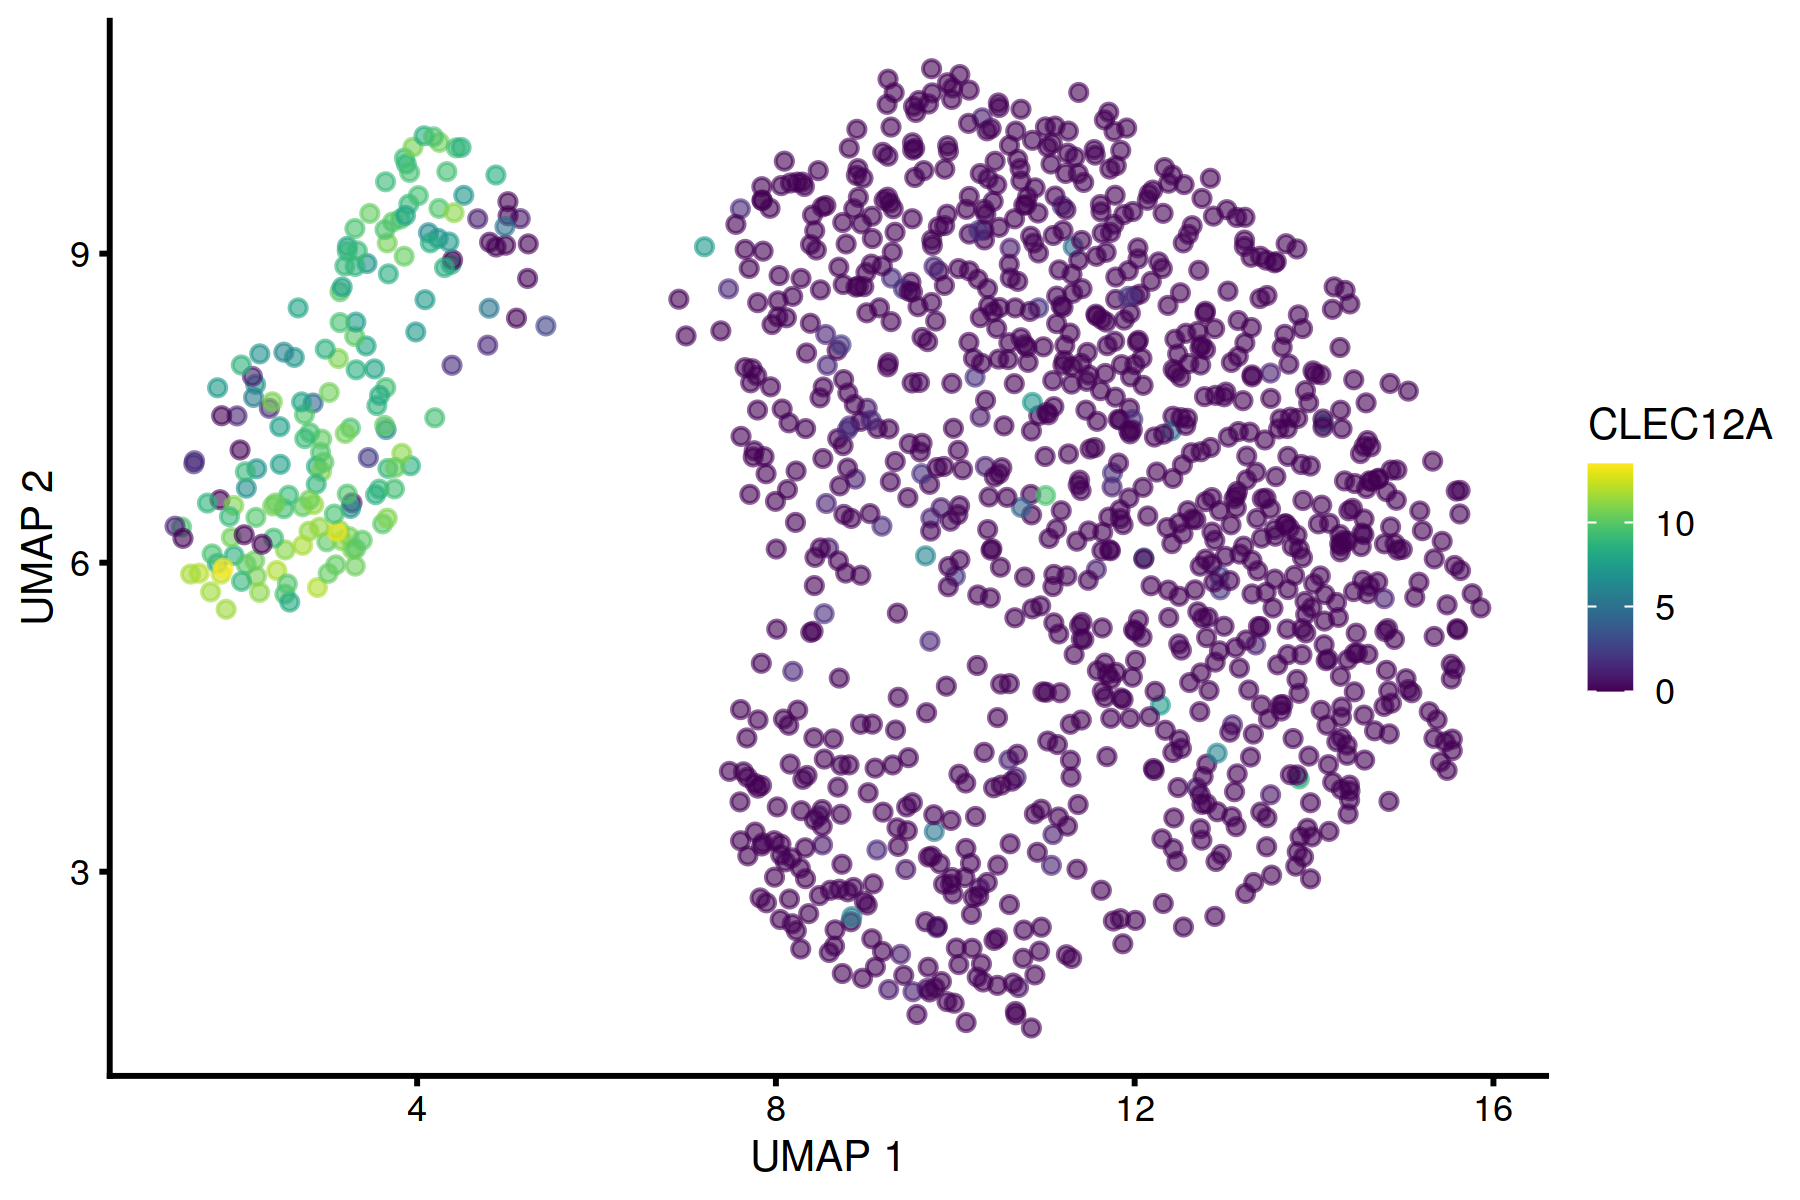

In [8]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 300)
plotUMAP(sce, colour_by = "CLEC12A")

In [72]:
saveRDS(sce, file = "../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_endothelial.rds")